In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
DATA_PATH = "/content/drive/MyDrive/01_Machain Learning/4. 텍스트 마이닝/data/topics"

In [18]:
import pandas as pd
import glob, os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 700)

In [19]:
# glob을 활용해 데이터 디렉토리 내에 있는 .data 파일 불러오기
all_files = glob.glob(os.path.join(DATA_PATH, "*.data"))

# 파일 이름을 저장할 리스트
file_names = []

# 파일 내용을 저장할 리스트
contents = []

# 각 .data 파일을 순회하며
for data_file in all_files:
    # .data 파일을 pandas 데이터프레임으로 읽어오기
    temp_df = pd.read_table(data_file, index_col=None, header=0, encoding='latin1')

    # 파일명 가져오기 (경로에서 파일명만 추출)
    file_name = data_file.split("/")[-1].split(".")[0]

    # 파일명 리스트에 추가
    file_names.append(file_name)

    # 파일 내용 리스트에 추가 (데이터프레임을 문자열로 변환하여 저장)
    contents.append(temp_df.to_string())

# 파일명과 내용으로 데이터프레임 생성
doc_df = pd.DataFrame({"filename": file_names, "content": contents})

# 데이터프레임의 상위 5개 행 출력
doc_df.head()

,filename,content
0,updates_garmin_nuvi_255W_gps,"Another thing to consider was that I paid $50 less for the 750 and it came with the FM transmitter cable and a USB cord to connect it to your computer for updates and downloads .\n0 update and reroute much _more_ quickly than my other GPS .\n1 UPDATE ON THIS , It finally turned out that to see the elevation contours at lowe..."
1,food_holiday_inn_london,The room was packed to capacity with queues at the food buffets .\n0 The over zealous staff cleared our unfinished drinks while we were collecting cooked food and movement around the room with plates was difficult in the crowded circumstances .\n1 ...
2,performance_netbook_1005ha,"The Eee Super Hybrid Engine utility lets users overclock or underclock their Eee PC's to boost performance or provide better battery life depending on their immediate requirements .\n0 In Super Performance mode CPU, Z shows the bus speed to increase up to 169 .\n1 One..."
3,service_bestwestern_hotel_sfo,"Both of us having worked in tourism for over 14 years were very disappointed at the level of service provided by this gentleman .\n0 The service was good, very friendly staff and we loved the free wine reception each night .\n1 ..."
4,video_ipod_nano_8gb,"I bought the 8, gig Ipod Nano that has the built, in video camera .\n0 Itunes has an on, line store, where you may purchase and download music and videos which will install onto the ipod .\n1 ..."


문서의 주제
- 호텔
- 자동차
- IT기기

# 전처리

In [20]:
import spacy

# spacy의 영어 모델 로드
nlp = spacy.load("en_core_web_sm")

# 문장 한 개에 대한 토큰화 처리 로직 정의
def my_tokenizer(text):
    # 입력 텍스트를 spacy를 사용해 토큰화
    doc = nlp(text)

    # 토큰의 기본형(lemma)을 리스트로 반환
    # 구두점(token.is_punct)과 불용어(token.is_stop)는 제외
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]


# TfidfVectorizer

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer 초기화
tfidf_vectorizer = TfidfVectorizer(
    # 커스텀 토크나이저 설정 (앞서 정의한 my_tokenizer 사용)
    tokenizer=my_tokenizer,
    # n-그램 범위 설정 (1에서 2까지의 n-그램을 사용)
    ngram_range=(1, 2),
    # 단어가 최소 5% 이상의 문서에서 나타나야 포함
    min_df=0.05,
    # 단어가 최대 95% 이하의 문서에서 나타나야 포함
    max_df=0.95
)

# 문서의 내용(content)들을 TF-IDF 벡터로 변환
feature_vector = tfidf_vectorizer.fit_transform(doc_df['content'])

# 변환된 TF-IDF 벡터 출력
feature_vector


<51x5475 sparse matrix of type '<class 'numpy.float64'>'
	with 40076 stored elements in Compressed Sparse Row format>

In [22]:
from sklearn.cluster import KMeans

# KMeans 클러스터링 알고리즘을 사용해 3개의 군집으로 분류
# n_clusters: 생성할 군집의 수를 3으로 설정
# max_iter: 최대 반복 횟수를 10000으로 설정하여 수렴할 때까지 충분히 반복
# random_state: 랜덤 시드 값을 42로 설정하여 결과의 재현성을 보장
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=42)

# TF-IDF 벡터화된 문서(feature_vector)를 사용해 KMeans 클러스터링을 학습
km_cluster.fit(feature_vector)


# 주어진 텍스트 데이터를 클러스터링하여 문서의 주제를 파악하고, 유사한 문서들을 그룹화함으로써 데이터의 구조를 이해하고 분석하려는 목적을 가지고 있습니다.

KMeans(max_iter=10000, n_clusters=3, random_state=42)

In [23]:
# 각 문서가 속한 클러스터 레이블을 확인
cluster_labels = km_cluster.labels_

# 각 문서의 클러스터 레이블 출력
cluster_labels

array([0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 2, 2, 2, 0,
       2, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2, 0, 2,
       0, 1, 2, 1, 0, 0, 1], dtype=int32)

In [24]:
# 각 클러스터의 중심 좌표(centroid)를 확인
cluster_centroids = km_cluster.cluster_centers_

# 각 클러스터의 중심 좌표 출력
cluster_centroids

array([[0.00117335, 0.00117335, 0.00117335, ..., 0.        , 0.00042688,
        0.        ],
       [0.00287498, 0.00287498, 0.00287498, ..., 0.        , 0.        ,
        0.        ],
       [0.00285515, 0.00285515, 0.00285515, ..., 0.00179301, 0.00741174,
        0.00143842]])

In [25]:
# 원본 데이터프레임에 클러스터 레이블을 새로운 열로 추가
doc_df['cluster_label'] = cluster_labels

# 클러스터 레이블을 기준으로 데이터프레임을 정렬하여 출력
doc_df.sort_values(by='cluster_label')

,filename,content,cluster_label
0,updates_garmin_nuvi_255W_gps,"Another thing to consider was that I paid $50 less for the 750 and it came with the FM transmitter cable and a USB cord to connect it to your computer for updates and downloads .\n0 update and reroute much _more_ quickly than my other GPS .\n1 UPDATE ON THIS , It finally turned out that to see the elevation contours at lowe...",0
48,features_windows7,"I had to uninstall anti, virus and selected other programs, some of which did not have listings in the Programs and Features Control Panel section .\n0 This review briefly touches upon some of the key features and enhancements of Microsoft's latest OS .\n1 ...",0
44,buttons_amazon_kindle,"I thought it would be fitting to christen my Kindle with the Stephen King novella UR, so went to the Amazon site on my computer and clicked on the button to buy it .\n0 As soon as I'd clicked the button to confirm my order it appeared on my Kindle almost immediately !\n1 ...",0
42,screen_ipod_nano_8gb,"As always, the video screen is sharp and bright .\n0 2, inch screen and a glossy, polished aluminum finish that one CNET editor described as looking like a Christmas tree ornament .\n1 ...",0
38,directions_garmin_nuvi_255W_gps,You also get upscale features like spoken directions including street names and programmable POIs .\n0 I used to hesitate to go out of my directions but no...,0
36,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n0 but for the most part, we find that the Garmin software provides accurate directions, whereever we intend to go .\n1 This functi...",0
33,eyesight-issues_amazon_kindle,"It feels as easy to read as the K1 but doesn't seem any crisper to my eyes .\n0 the white is really GREY, and to avoid considerable eye, strain I had to refresh pages every other page .\n1 The dream has always been a portable electronic device that could hold a ton of reading material, automate subscriptions and fa...",0
32,navigation_amazon_kindle,"In fact, the entire navigation structure has been completely revised , I'm still getting used to it but it's a huge step forward .\n0 ...",0
31,screen_netbook_1005ha,Keep in mind that once you get in a room full of light or step outdoors screen reflections could become annoying .\n0 I've used mine outsi...,0
28,price_amazon_kindle,"If a case was included, as with the Kindle 1, that would have been reflected in a higher price .\n0 lower overall price, with nice leather cover .\n1 ...",0


# 군집 별 핵심 단어 추출하기


In [34]:
# cluster_model : 군집 모델
# cluster_data : 데이터 프레임
# feature_names : 단어 목록
# cluster_num : 클러스터 개수
# top_n_features : 대표 단어 몇 개를 볼 것인지 결정

def get_cluster_details(cluster_model, cluster_data, feature_names, cluster_num, top_n_features=10):

  # top N feature, 파일 이름, feature tf-idf값
  cluster_details = {}
  # 군집 세부 정보를 담을 빈 딕셔너리 생성

  # 군집의 센트로이드 좌표를 얻어내기
  cluster_centroid = cluster_model.cluster_centers_
  # 군집의 중심점을 얻어냅니다. 중심점은 각 군집을 대표하는 좌표입니다.

  # centroid 좌표의 제일 큰 값이 그 군집의 핵심 단어
  center_features = cluster_centroid.argsort()[:, ::-1]
  # 중심점 좌표에서 큰 값을 가지는 단어 순서대로 정렬합니다.

  #  각 군집 별 순환을 통해 핵심 단어, feature 값(tfidf값), 각 군집에 속해있는 파일이름 얻어내기
  for c_num in range(cluster_num):

    # 군집 별 데이터를 담아낼 준비
    cluster_details[c_num] = {}

    cluster_details[c_num]['cluster'] = c_num # 클러스터 번호 담기
    # 군집 번호 저장

    # 핵심 단어 목록 담아주기 (top N개)
    top_n_feature_indexes = center_features[c_num, :top_n_features]
    # 해당 군집에서 상위 N개의 핵심 단어 인덱스를 가져옵니다.
    top_features = [ feature_names[idx] for idx in top_n_feature_indexes ]
    # 인덱스를 이용해 실제 단어를 가져와서 리스트에 저장합니다.
    cluster_details[c_num]['top_features'] = top_features
    # 군집 세부 정보에 상위 N개의 핵심 단어 목록을 저장합니다.

    # 핵심이 되는 단어들의 tfidf값
    top_n_feature_values = cluster_centroid[c_num, top_n_feature_indexes].tolist()
    # 상위 N개의 핵심 단어들의 tf-idf 값을 가져와서 리스트로 변환합니다.
    cluster_details[c_num]['top_feature_value'] = top_n_feature_values
    # 군집 세부 정보에 상위 N개의 핵심 단어 tf-idf 값을 저장합니다.

    # 군집에 포함된 파일명 담아주기
    file_names = cluster_data[cluster_data['cluster_label'] == c_num]['filename']
    # 해당 군집에 속하는 파일 이름들을 가져옵니다.
    file_names = file_names.tolist()
    # 파일 이름을 리스트로 변환합니다.

    cluster_details[c_num]['filenames'] = file_names
    # 군집 세부 정보에 파일 이름 리스트를 저장합니다.

  return cluster_details
  # 군집 세부 정보를 반환합니다.


In [35]:
cluster_detail_info = get_cluster_details(
    cluster_model = km_cluster,
    cluster_data = doc_df,
    feature_names = tfidf_vectorizer.get_feature_names_out(), # get_feature_names_out : tfidf의 단어 목록
    cluster_num=3
)

pd.DataFrame(cluster_detail_info)

,0,1,2
cluster,0,1,2
top_features,"[screen, battery, keyboard, battery life, life, kindle, video, direction, feature, voice]","[interior, seat, mileage, comfortable, gas, gas mileage, transmission, car, performance, quality]","[room, hotel, service, staff, food, location, bathroom, clean, price, parking]"
top_feature_value,"[0.131645181247185, 0.11656014630766626, 0.0622720061234738, 0.0617784656984276, 0.05716941309848697, 0.05497808378030129, 0.052833091199825793, 0.0517686631399994, 0.05006145890014061, 0.050033583976124556]","[0.22305246585437022, 0.18897054299685095, 0.1719313820593925, 0.1220969855807613, 0.11878932687600363, 0.11290839434599471, 0.1024927264248041, 0.09762331306326871, 0.09295950080989267, 0.08915442463334122]","[0.26063301032402875, 0.1975783642057278, 0.17580581232763162, 0.14911209760337724, 0.12570028548772472, 0.12338129254048336, 0.07332449089770955, 0.06974511566128655, 0.06055176112175157, 0.05561469412253178]"
filenames,"[updates_garmin_nuvi_255W_gps, performance_netbook_1005ha, video_ipod_nano_8gb, satellite_garmin_nuvi_255W_gps, battery-life_netbook_1005ha, keyboard_netbook_1005ha, battery-life_amazon_kindle, screen_garmin_nuvi_255W_gps, speed_garmin_nuvi_255W_gps, voice_garmin_nuvi_255W_gps, size_asus_netbook_1005ha, battery-life_ipod_nano_8gb, display_garmin_nuvi_255W_gps, speed_windows7, fonts_amazon_kindle, price_amazon_kindle, screen_netbook_1005ha, navigation_amazon_kindle, eyesight-issues_amazon_kindle, accuracy_garmin_nuvi_255W_gps, directions_garmin_nuvi_255W_gps, screen_ipod_nano_8gb, buttons_amazon_kindle, features_windows7, sound_ipod_nano_8gb]","[gas_mileage_toyota_camry_2007, performance_honda_accord_2008, comfort_toyota_camry_2007, quality_toyota_camry_2007, interior_honda_accord_2008, mileage_honda_accord_2008, seats_honda_accord_2008, interior_toyota_camry_2007, transmission_toyota_camry_2007, comfort_honda_accord_2008]","[food_holiday_inn_london, service_bestwestern_hotel_sfo, service_swissotel_hotel_chicago, staff_bestwestern_hotel_sfo, location_holiday_inn_london, room_holiday_inn_london, parking_bestwestern_hotel_sfo, free_bestwestern_hotel_sfo, rooms_bestwestern_hotel_sfo, location_bestwestern_hotel_sfo, rooms_swissotel_chicago, food_swissotel_chicago, bathroom_bestwestern_hotel_sfo, price_holiday_inn_london, service_holiday_inn_london, staff_swissotel_chicago]"


# 문서 유사도
- 코사인 유사도 활용

In [36]:
# 문서 리스트를 정의합니다.
doc_list = ['맛있는 사과 사과 사과 바나나',
            '사과 사과 바나나 오렌지 멜론 사과',
            '이게 제가 할 일이에요? 사과']

# TF-IDF 벡터라이저 객체를 생성합니다.
tfidf_vect_simple = TfidfVectorizer()

# 문서 리스트를 TF-IDF 벡터화합니다.
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)



feature_vect_simple

<3x8 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [37]:
# 벡터화된 결과를 데이터프레임으로 변환하여 각 단어의 TF-IDF 값을 확인합니다.
pd.DataFrame(
    feature_vect_simple.toarray(),  # TF-IDF 행렬을 배열 형태로 변환합니다.
    columns=tfidf_vect_simple.get_feature_names_out()  # 각 열에 해당하는 단어 이름을 가져옵니다.
)


,맛있는,멜론,바나나,사과,오렌지,이게,일이에요,제가
0,0.460392,0.0000,0.350140,0.815745,0.0000,0.000000,0.000000,0.000000
1,0.000000,0.4182,0.318052,0.740987,0.4182,0.000000,0.000000,0.000000
2,0.000000,0.0000,0.000000,0.322745,0.0000,0.546454,0.546454,0.546454


In [42]:
from sklearn.metrics.pairwise import cosine_similarity

# 각 문서 간의 코사인 유사도를 계산합니다.
similarity_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)

# 계산된 코사인 유사도 결과를 출력합니다.
similarity_pair

array([[1.        , 0.71581911, 0.26327739],
       [0.71581911, 1.        , 0.23914936],
       [0.26327739, 0.23914936, 1.        ]])

In [41]:
# 첫 번째 문서와 모든 문서 간의 코사인 유사도를 계산합니다.
similarity_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)

# 계산된 코사인 유사도 결과를 출력합니다.
similarity_pair

array([[1.        , 0.71581911, 0.26327739]])

2번 클러스터 안에서 [0]과 비슷한 문서를 찾기

In [45]:
# doc_df라는 데이터프레임에서 cluster_label이 2인 문서들의 인덱스를 추출합니다.
cluster_2_indexes = doc_df[doc_df['cluster_label'] == 2].index
cluster_2_indexes

Index([1, 3, 8, 11, 15, 18, 19, 20, 22, 30, 34, 35, 37, 41, 43, 46], dtype='int64')

In [46]:
# 클러스터 2의 첫 번째 문서 이름을 추출합니다.
compair_docname = doc_df.iloc[cluster_2_indexes[0]]['filename']

compair_docname

'food_holiday_inn_london'

In [47]:
# 클러스터 2의 첫 번째 문서와 클러스터 2 내의 모든 문서 간의 코사인 유사도를 계산합니다.
similarity_pair = cosine_similarity(
    feature_vector[cluster_2_indexes[0]].reshape(1, -1),  # 기준으로 삼을 문서의 벡터 추출
    feature_vector[cluster_2_indexes]  # 클러스터 2번의 모든 문서의 벡터"들" 추출
)

In [48]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 유사도 값을 기준으로 문서 인덱스를 내림차순으로 정렬합니다.
sorted_index = similarity_pair.argsort()[:, ::-1]
# 자기 자신과의 유사도는 제외하고 나머지 인덱스를 가져옵니다.
sorted_index = sorted_index[:, 1:]

# 정렬된 인덱스를 출력합니다.
sorted_index

array([[11, 14,  1,  2, 13,  4,  5,  8, 10,  3,  9, 15,  7,  6, 12]])

In [49]:
# 유사도가 큰 순으로 cluster_2_indexes를 재정렬합니다.
cluster2_sorted_indexes = cluster_2_indexes[sorted_index.reshape(-1)]

# 재정렬된 클러스터 2의 문서 인덱스를 출력합니다.
cluster2_sorted_indexes


Index([35, 43, 3, 8, 41, 15, 18, 22, 34, 11, 30, 46, 20, 19, 37], dtype='int64')

In [50]:
# 유사도 값을 내림차순으로 정렬하여 가져옵니다.
cluster2_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
# 자기 자신과의 유사도는 제외합니다.
cluster2_sim_value = cluster2_sim_value[1:]

# 유사도 값을 출력합니다.
cluster2_sim_value


array([0.83495294, 0.33906324, 0.29651784, 0.24745511, 0.23007553,
       0.18724185, 0.16887871, 0.13976889, 0.13196534, 0.12570069,
       0.11392122, 0.10617754, 0.06739191, 0.05721217, 0.04657922])

In [ ]:
# 데이터프레임을 생성합니다.
cluster2_sim_df = pd.DataFrame()
# 정렬된 문서 인덱스에 해당하는 파일 이름을 데이터프레임에 추가합니다.
cluster2_sim_df['filename'] = doc_df.iloc[cluster2_sorted_indexes]['filename']
# 유사도 값을 데이터프레임에 추가합니다.
cluster2_sim_df['similarity'] = cluster2_sim_value

# 클러스터 2번의 0번 문서와 가장 유사한 파일 이름 및 유사도를 출력합니다.
print("클러스터 2번의 0번 문서와 가장 유사한 파일 이름 및 유사도: \n{}".format(cluster2_sim_df.iloc[0, :]))


클러스터 2번의 0번 문서와 가장 유사한 파일 이름 및 유사도: 
filename      interior_honda_accord_2008
similarity                      0.917015
Name: 20, dtype: object


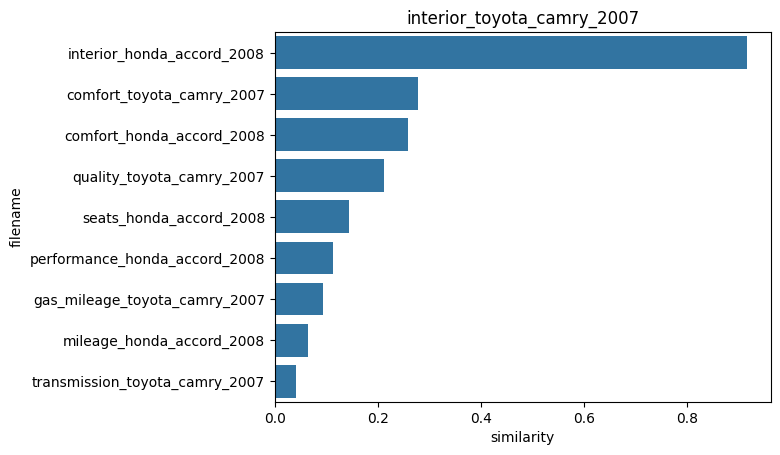

In [ ]:
# 유사도를 막대 그래프로 시각화합니다.
sns.barplot(x='similarity', y='filename', data=cluster2_sim_df)
plt.title(compair_docname)
plt.show()